## Load normalized data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import models
from keras import layers
import numpy as np

normalized_data = pd.read_csv("normalized_data.csv", index_col=0)
normalized_data

Using TensorFlow backend.


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.271174,0.2,0.000000,0.014151,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.472229,0.2,0.000000,0.139136,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.434531,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,1.0,NaN,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,NaN,0.0,0.484795,0.0,0.000000,0.212559,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,NaN,1.0,0.478512,0.0,0.000000,0.014151,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Counting empty values

In [2]:
empty_values = [(label, normalized_data[label].isnull().sum()) for label in normalized_data.columns.values]
sorted(empty_values, reverse=True, key=lambda tup: tup[1])

[('Survived', 418),
 ('Age', 263),
 ('Pclass', 0),
 ('SibSp', 0),
 ('Parch', 0),
 ('Fare', 0),
 ('female', 0),
 ('male', 0),
 ('C', 0),
 ('Q', 0),
 ('S', 0),
 ('Mr', 0),
 ('Miss', 0),
 ('Mrs', 0),
 ('PC', 0),
 ('C.A.', 0),
 ('SOTON/O.Q.', 0),
 ('2.', 0),
 ('W./C.', 0),
 ('STON/O', 0),
 ('CA.', 0),
 ('A/5', 0),
 ('SC/PARIS', 0),
 ('2343', 0),
 ('CA', 0),
 ('A/5.', 0)]

## Separate samples with and without age

In [3]:
samples_with_age = normalized_data[normalized_data.Age.notna()]
samples_without_age = normalized_data[normalized_data.Age.isna()]

## Creating model for age prediction

In [4]:
x_train_age = samples_with_age.drop(["Age", "Survived"], axis=1).values
y_train_age = samples_with_age["Age"].values

number_of_epochs = 80
number_of_folds = 5
number_of_samples = len(x_train_age) // number_of_folds

all_mae_histories = []
all_val_mae_histories = []
for i in range(number_of_folds):
    print('processing fold #', i)
    partial_x_train_age = np.concatenate([x_train_age[:i*number_of_samples], x_train_age[(i+1)*number_of_samples:]])
    parital_y_train_age = np.concatenate([y_train_age[:i*number_of_samples], y_train_age[(i+1)*number_of_samples:]])
    
    partial_x_validation_age = x_train_age[i*number_of_samples:(i+1)*number_of_samples]
    partial_y_validation_age = y_train_age[i*number_of_samples:(i+1)*number_of_samples]

    model = models.Sequential()
    model.add(layers.Dense(x_train_age.shape[1], activation="relu", input_shape=(x_train_age.shape[1],)))
    model.add(layers.Dense(12, activation="relu"))
    model.add(layers.Dense(1))

    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae"])

    history = model.fit(partial_x_train_age,
                        parital_y_train_age,
                        epochs=number_of_epochs,
                        batch_size=16,
                        validation_data=(partial_x_validation_age, partial_y_validation_age))
    all_mae_histories.append(history.history['mae'])
    all_val_mae_histories.append(history.history['val_mae'])


processing fold # 0
Train on 837 samples, validate on 209 samples
Epoch 1/500
837/837 [==============================] - 0s 242us/step - loss: 0.0590 - mae: 0.1903 - val_loss: 0.0373 - val_mae: 0.1512
Epoch 2/500
837/837 [==============================] - 0s 125us/step - loss: 0.0312 - mae: 0.1392 - val_loss: 0.0252 - val_mae: 0.1256
Epoch 3/500
837/837 [==============================] - 0s 132us/step - loss: 0.0246 - mae: 0.1230 - val_loss: 0.0237 - val_mae: 0.1164
Epoch 4/500
837/837 [==============================] - 0s 129us/step - loss: 0.0228 - mae: 0.1183 - val_loss: 0.0230 - val_mae: 0.1196
Epoch 5/500
837/837 [==============================] - 0s 127us/step - loss: 0.0220 - mae: 0.1159 - val_loss: 0.0234 - val_mae: 0.1140
Epoch 6/500
837/837 [==============================] - 0s 117us/step - loss: 0.0218 - mae: 0.1146 - val_loss: 0.0230 - val_mae: 0.1145
Epoch 7/500
837/837 [==============================] - 0s 131us/step - loss: 0.0212 - mae: 0.1138 - val_loss: 0.0214 - val_m

Epoch 61/500
837/837 [==============================] - 0s 120us/step - loss: 0.0169 - mae: 0.0987 - val_loss: 0.0215 - val_mae: 0.1115
Epoch 62/500
837/837 [==============================] - 0s 124us/step - loss: 0.0168 - mae: 0.0980 - val_loss: 0.0220 - val_mae: 0.1139
Epoch 63/500
837/837 [==============================] - 0s 115us/step - loss: 0.0168 - mae: 0.0984 - val_loss: 0.0211 - val_mae: 0.1100
Epoch 64/500
837/837 [==============================] - 0s 119us/step - loss: 0.0168 - mae: 0.0983 - val_loss: 0.0218 - val_mae: 0.1130
Epoch 65/500
837/837 [==============================] - 0s 118us/step - loss: 0.0168 - mae: 0.0976 - val_loss: 0.0223 - val_mae: 0.1156
Epoch 66/500
837/837 [==============================] - 0s 111us/step - loss: 0.0165 - mae: 0.0978 - val_loss: 0.0227 - val_mae: 0.1126
Epoch 67/500
837/837 [==============================] - 0s 114us/step - loss: 0.0166 - mae: 0.0974 - val_loss: 0.0226 - val_mae: 0.1165
Epoch 68/500
837/837 [==========================

837/837 [==============================] - 0s 120us/step - loss: 0.0155 - mae: 0.0931 - val_loss: 0.0224 - val_mae: 0.1119
Epoch 122/500
837/837 [==============================] - 0s 119us/step - loss: 0.0157 - mae: 0.0931 - val_loss: 0.0217 - val_mae: 0.1116
Epoch 123/500
837/837 [==============================] - 0s 110us/step - loss: 0.0156 - mae: 0.0930 - val_loss: 0.0218 - val_mae: 0.1117
Epoch 124/500
837/837 [==============================] - 0s 124us/step - loss: 0.0157 - mae: 0.0932 - val_loss: 0.0218 - val_mae: 0.1115
Epoch 125/500
837/837 [==============================] - 0s 117us/step - loss: 0.0155 - mae: 0.0928 - val_loss: 0.0225 - val_mae: 0.1129
Epoch 126/500
837/837 [==============================] - 0s 111us/step - loss: 0.0156 - mae: 0.0930 - val_loss: 0.0216 - val_mae: 0.1120
Epoch 127/500
837/837 [==============================] - 0s 116us/step - loss: 0.0156 - mae: 0.0932 - val_loss: 0.0230 - val_mae: 0.1177
Epoch 128/500
837/837 [==============================] 

Epoch 181/500
837/837 [==============================] - 0s 112us/step - loss: 0.0150 - mae: 0.0907 - val_loss: 0.0226 - val_mae: 0.1119
Epoch 182/500
837/837 [==============================] - 0s 109us/step - loss: 0.0150 - mae: 0.0896 - val_loss: 0.0222 - val_mae: 0.1129
Epoch 183/500
837/837 [==============================] - 0s 118us/step - loss: 0.0151 - mae: 0.0912 - val_loss: 0.0222 - val_mae: 0.1128
Epoch 184/500
837/837 [==============================] - 0s 123us/step - loss: 0.0151 - mae: 0.0917 - val_loss: 0.0225 - val_mae: 0.1118
Epoch 185/500
837/837 [==============================] - ETA: 0s - loss: 0.0146 - mae: 0.088 - 0s 116us/step - loss: 0.0149 - mae: 0.0898 - val_loss: 0.0221 - val_mae: 0.1117
Epoch 186/500
837/837 [==============================] - 0s 117us/step - loss: 0.0148 - mae: 0.0901 - val_loss: 0.0245 - val_mae: 0.1221
Epoch 187/500
837/837 [==============================] - 0s 119us/step - loss: 0.0150 - mae: 0.0911 - val_loss: 0.0229 - val_mae: 0.1125
Epo

837/837 [==============================] - 0s 126us/step - loss: 0.0145 - mae: 0.0885 - val_loss: 0.0229 - val_mae: 0.1136
Epoch 241/500
837/837 [==============================] - 0s 108us/step - loss: 0.0145 - mae: 0.0891 - val_loss: 0.0238 - val_mae: 0.1168
Epoch 242/500
837/837 [==============================] - 0s 128us/step - loss: 0.0146 - mae: 0.0882 - val_loss: 0.0232 - val_mae: 0.1148
Epoch 243/500
837/837 [==============================] - 0s 116us/step - loss: 0.0146 - mae: 0.0891 - val_loss: 0.0238 - val_mae: 0.1181
Epoch 244/500
837/837 [==============================] - 0s 121us/step - loss: 0.0146 - mae: 0.0891 - val_loss: 0.0225 - val_mae: 0.1116
Epoch 245/500
837/837 [==============================] - 0s 116us/step - loss: 0.0144 - mae: 0.0885 - val_loss: 0.0238 - val_mae: 0.1155
Epoch 246/500
837/837 [==============================] - 0s 118us/step - loss: 0.0146 - mae: 0.0892 - val_loss: 0.0230 - val_mae: 0.1128
Epoch 247/500
837/837 [==============================] 

Epoch 300/500
837/837 [==============================] - 0s 113us/step - loss: 0.0141 - mae: 0.0869 - val_loss: 0.0257 - val_mae: 0.1227
Epoch 301/500
837/837 [==============================] - 0s 122us/step - loss: 0.0142 - mae: 0.0881 - val_loss: 0.0237 - val_mae: 0.1144
Epoch 302/500
837/837 [==============================] - 0s 112us/step - loss: 0.0142 - mae: 0.0877 - val_loss: 0.0238 - val_mae: 0.1158
Epoch 303/500
837/837 [==============================] - 0s 113us/step - loss: 0.0142 - mae: 0.0876 - val_loss: 0.0234 - val_mae: 0.1134
Epoch 304/500
837/837 [==============================] - 0s 121us/step - loss: 0.0143 - mae: 0.0876 - val_loss: 0.0231 - val_mae: 0.1128
Epoch 305/500
837/837 [==============================] - 0s 116us/step - loss: 0.0141 - mae: 0.0871 - val_loss: 0.0245 - val_mae: 0.1182
Epoch 306/500
837/837 [==============================] - 0s 113us/step - loss: 0.0144 - mae: 0.0880 - val_loss: 0.0232 - val_mae: 0.1125
Epoch 307/500
837/837 [==================

Epoch 360/500
837/837 [==============================] - 0s 123us/step - loss: 0.0140 - mae: 0.0858 - val_loss: 0.0243 - val_mae: 0.1150
Epoch 361/500
837/837 [==============================] - 0s 117us/step - loss: 0.0140 - mae: 0.0866 - val_loss: 0.0234 - val_mae: 0.1131
Epoch 362/500
837/837 [==============================] - 0s 111us/step - loss: 0.0141 - mae: 0.0869 - val_loss: 0.0240 - val_mae: 0.1150
Epoch 363/500
837/837 [==============================] - 0s 118us/step - loss: 0.0139 - mae: 0.0866 - val_loss: 0.0235 - val_mae: 0.1143
Epoch 364/500
837/837 [==============================] - 0s 121us/step - loss: 0.0140 - mae: 0.0873 - val_loss: 0.0239 - val_mae: 0.1142
Epoch 365/500
837/837 [==============================] - 0s 113us/step - loss: 0.0139 - mae: 0.0849 - val_loss: 0.0242 - val_mae: 0.1146
Epoch 366/500
837/837 [==============================] - 0s 117us/step - loss: 0.0139 - mae: 0.0863 - val_loss: 0.0241 - val_mae: 0.1169
Epoch 367/500
837/837 [==================

Epoch 420/500
837/837 [==============================] - 0s 109us/step - loss: 0.0138 - mae: 0.0861 - val_loss: 0.0248 - val_mae: 0.1195
Epoch 421/500
837/837 [==============================] - 0s 118us/step - loss: 0.0136 - mae: 0.0854 - val_loss: 0.0250 - val_mae: 0.1190
Epoch 422/500
837/837 [==============================] - 0s 117us/step - loss: 0.0138 - mae: 0.0859 - val_loss: 0.0242 - val_mae: 0.1148
Epoch 423/500
837/837 [==============================] - 0s 113us/step - loss: 0.0140 - mae: 0.0865 - val_loss: 0.0237 - val_mae: 0.1171
Epoch 424/500
837/837 [==============================] - 0s 122us/step - loss: 0.0138 - mae: 0.0863 - val_loss: 0.0238 - val_mae: 0.1146
Epoch 425/500
837/837 [==============================] - 0s 117us/step - loss: 0.0138 - mae: 0.0853 - val_loss: 0.0241 - val_mae: 0.1142
Epoch 426/500
837/837 [==============================] - 0s 112us/step - loss: 0.0137 - mae: 0.0846 - val_loss: 0.0237 - val_mae: 0.1129
Epoch 427/500
837/837 [==================

Epoch 480/500
837/837 [==============================] - 0s 110us/step - loss: 0.0134 - mae: 0.0839 - val_loss: 0.0248 - val_mae: 0.1186
Epoch 481/500
837/837 [==============================] - 0s 115us/step - loss: 0.0135 - mae: 0.0849 - val_loss: 0.0250 - val_mae: 0.1147
Epoch 482/500
837/837 [==============================] - 0s 120us/step - loss: 0.0135 - mae: 0.0850 - val_loss: 0.0255 - val_mae: 0.1153
Epoch 483/500
837/837 [==============================] - 0s 118us/step - loss: 0.0135 - mae: 0.0856 - val_loss: 0.0255 - val_mae: 0.1159
Epoch 484/500
837/837 [==============================] - 0s 119us/step - loss: 0.0136 - mae: 0.0854 - val_loss: 0.0249 - val_mae: 0.1165
Epoch 485/500
837/837 [==============================] - 0s 119us/step - loss: 0.0135 - mae: 0.0845 - val_loss: 0.0250 - val_mae: 0.1157
Epoch 486/500
837/837 [==============================] - 0s 163us/step - loss: 0.0135 - mae: 0.0852 - val_loss: 0.0252 - val_mae: 0.1174
Epoch 487/500
837/837 [==================

837/837 [==============================] - 0s 123us/step - loss: 0.0172 - mae: 0.1009 - val_loss: 0.0206 - val_mae: 0.1065
Epoch 40/500
837/837 [==============================] - 0s 120us/step - loss: 0.0175 - mae: 0.1010 - val_loss: 0.0203 - val_mae: 0.1081
Epoch 41/500
837/837 [==============================] - 0s 151us/step - loss: 0.0172 - mae: 0.1006 - val_loss: 0.0208 - val_mae: 0.1108
Epoch 42/500
837/837 [==============================] - 0s 163us/step - loss: 0.0171 - mae: 0.0999 - val_loss: 0.0205 - val_mae: 0.1092
Epoch 43/500
837/837 [==============================] - 0s 117us/step - loss: 0.0171 - mae: 0.1005 - val_loss: 0.0205 - val_mae: 0.1058
Epoch 44/500
837/837 [==============================] - 0s 116us/step - loss: 0.0171 - mae: 0.1005 - val_loss: 0.0217 - val_mae: 0.1119
Epoch 45/500
837/837 [==============================] - 0s 116us/step - loss: 0.0171 - mae: 0.1001 - val_loss: 0.0210 - val_mae: 0.1068
Epoch 46/500
837/837 [==============================] - 0s 11

837/837 [==============================] - 0s 117us/step - loss: 0.0156 - mae: 0.0946 - val_loss: 0.0203 - val_mae: 0.1043
Epoch 100/500
837/837 [==============================] - 0s 120us/step - loss: 0.0156 - mae: 0.0940 - val_loss: 0.0212 - val_mae: 0.1064
Epoch 101/500
837/837 [==============================] - 0s 118us/step - loss: 0.0156 - mae: 0.0939 - val_loss: 0.0207 - val_mae: 0.1120
Epoch 102/500
837/837 [==============================] - 0s 113us/step - loss: 0.0156 - mae: 0.0940 - val_loss: 0.0200 - val_mae: 0.1058
Epoch 103/500
837/837 [==============================] - 0s 112us/step - loss: 0.0154 - mae: 0.0940 - val_loss: 0.0206 - val_mae: 0.1095
Epoch 104/500
837/837 [==============================] - 0s 116us/step - loss: 0.0155 - mae: 0.0954 - val_loss: 0.0205 - val_mae: 0.1061
Epoch 105/500
837/837 [==============================] - 0s 115us/step - loss: 0.0154 - mae: 0.0938 - val_loss: 0.0212 - val_mae: 0.1061
Epoch 106/500
837/837 [==============================] 

Epoch 159/500
837/837 [==============================] - 0s 121us/step - loss: 0.0149 - mae: 0.0913 - val_loss: 0.0203 - val_mae: 0.1035
Epoch 160/500
837/837 [==============================] - 0s 113us/step - loss: 0.0148 - mae: 0.0899 - val_loss: 0.0207 - val_mae: 0.1108
Epoch 161/500
837/837 [==============================] - 0s 121us/step - loss: 0.0149 - mae: 0.0909 - val_loss: 0.0206 - val_mae: 0.1088
Epoch 162/500
837/837 [==============================] - 0s 110us/step - loss: 0.0148 - mae: 0.0906 - val_loss: 0.0207 - val_mae: 0.1044
Epoch 163/500
837/837 [==============================] - 0s 120us/step - loss: 0.0148 - mae: 0.0908 - val_loss: 0.0200 - val_mae: 0.1068
Epoch 164/500
837/837 [==============================] - 0s 118us/step - loss: 0.0149 - mae: 0.0917 - val_loss: 0.0211 - val_mae: 0.1064
Epoch 165/500
837/837 [==============================] - 0s 112us/step - loss: 0.0149 - mae: 0.0916 - val_loss: 0.0204 - val_mae: 0.1040
Epoch 166/500
837/837 [==================

Epoch 219/500
837/837 [==============================] - 0s 137us/step - loss: 0.0145 - mae: 0.0888 - val_loss: 0.0206 - val_mae: 0.1043
Epoch 220/500
837/837 [==============================] - 0s 121us/step - loss: 0.0144 - mae: 0.0895 - val_loss: 0.0201 - val_mae: 0.1050
Epoch 221/500
837/837 [==============================] - 0s 121us/step - loss: 0.0144 - mae: 0.0888 - val_loss: 0.0207 - val_mae: 0.1078
Epoch 222/500
837/837 [==============================] - 0s 118us/step - loss: 0.0144 - mae: 0.0892 - val_loss: 0.0205 - val_mae: 0.1055
Epoch 223/500
837/837 [==============================] - 0s 113us/step - loss: 0.0143 - mae: 0.0884 - val_loss: 0.0211 - val_mae: 0.1103
Epoch 224/500
837/837 [==============================] - 0s 111us/step - loss: 0.0143 - mae: 0.0890 - val_loss: 0.0199 - val_mae: 0.1034
Epoch 225/500
837/837 [==============================] - 0s 126us/step - loss: 0.0144 - mae: 0.0884 - val_loss: 0.0196 - val_mae: 0.1050
Epoch 226/500
837/837 [==================

Epoch 279/500
837/837 [==============================] - 0s 125us/step - loss: 0.0144 - mae: 0.0882 - val_loss: 0.0195 - val_mae: 0.1020
Epoch 280/500
837/837 [==============================] - 0s 126us/step - loss: 0.0139 - mae: 0.0867 - val_loss: 0.0205 - val_mae: 0.1085
Epoch 281/500
837/837 [==============================] - 0s 108us/step - loss: 0.0141 - mae: 0.0869 - val_loss: 0.0218 - val_mae: 0.1127
Epoch 282/500
837/837 [==============================] - 0s 115us/step - loss: 0.0140 - mae: 0.0872 - val_loss: 0.0207 - val_mae: 0.1032
Epoch 283/500
837/837 [==============================] - 0s 120us/step - loss: 0.0142 - mae: 0.0872 - val_loss: 0.0217 - val_mae: 0.1138
Epoch 284/500
837/837 [==============================] - 0s 118us/step - loss: 0.0142 - mae: 0.0876 - val_loss: 0.0204 - val_mae: 0.1047
Epoch 285/500
837/837 [==============================] - 0s 115us/step - loss: 0.0141 - mae: 0.0871 - val_loss: 0.0198 - val_mae: 0.1059
Epoch 286/500
837/837 [==================

Epoch 339/500
837/837 [==============================] - 0s 116us/step - loss: 0.0139 - mae: 0.0862 - val_loss: 0.0210 - val_mae: 0.1071
Epoch 340/500
837/837 [==============================] - 0s 115us/step - loss: 0.0140 - mae: 0.0868 - val_loss: 0.0201 - val_mae: 0.1031
Epoch 341/500
837/837 [==============================] - 0s 120us/step - loss: 0.0140 - mae: 0.0858 - val_loss: 0.0204 - val_mae: 0.1061
Epoch 342/500
837/837 [==============================] - 0s 120us/step - loss: 0.0139 - mae: 0.0866 - val_loss: 0.0201 - val_mae: 0.1079
Epoch 343/500
837/837 [==============================] - 0s 114us/step - loss: 0.0139 - mae: 0.0871 - val_loss: 0.0205 - val_mae: 0.1033
Epoch 344/500
837/837 [==============================] - 0s 115us/step - loss: 0.0139 - mae: 0.0863 - val_loss: 0.0203 - val_mae: 0.1028
Epoch 345/500
837/837 [==============================] - 0s 118us/step - loss: 0.0139 - mae: 0.0865 - val_loss: 0.0210 - val_mae: 0.1092
Epoch 346/500
837/837 [==================

Epoch 399/500
837/837 [==============================] - 0s 116us/step - loss: 0.0139 - mae: 0.0865 - val_loss: 0.0206 - val_mae: 0.1102
Epoch 400/500
837/837 [==============================] - 0s 114us/step - loss: 0.0138 - mae: 0.0861 - val_loss: 0.0198 - val_mae: 0.1021
Epoch 401/500
837/837 [==============================] - 0s 158us/step - loss: 0.0139 - mae: 0.0867 - val_loss: 0.0206 - val_mae: 0.1063
Epoch 402/500
837/837 [==============================] - 0s 155us/step - loss: 0.0140 - mae: 0.0860 - val_loss: 0.0203 - val_mae: 0.1058
Epoch 403/500
837/837 [==============================] - 0s 114us/step - loss: 0.0139 - mae: 0.0860 - val_loss: 0.0204 - val_mae: 0.1056
Epoch 404/500
837/837 [==============================] - 0s 128us/step - loss: 0.0138 - mae: 0.0861 - val_loss: 0.0208 - val_mae: 0.1042
Epoch 405/500
837/837 [==============================] - 0s 195us/step - loss: 0.0139 - mae: 0.0855 - val_loss: 0.0204 - val_mae: 0.1066
Epoch 406/500
837/837 [==================

Epoch 459/500
837/837 [==============================] - 0s 128us/step - loss: 0.0139 - mae: 0.0860 - val_loss: 0.0199 - val_mae: 0.1025
Epoch 460/500
837/837 [==============================] - 0s 164us/step - loss: 0.0137 - mae: 0.0853 - val_loss: 0.0197 - val_mae: 0.1030
Epoch 461/500
837/837 [==============================] - 0s 167us/step - loss: 0.0137 - mae: 0.0855 - val_loss: 0.0216 - val_mae: 0.1134
Epoch 462/500
837/837 [==============================] - 0s 120us/step - loss: 0.0137 - mae: 0.0859 - val_loss: 0.0204 - val_mae: 0.1035
Epoch 463/500
837/837 [==============================] - 0s 119us/step - loss: 0.0137 - mae: 0.0850 - val_loss: 0.0212 - val_mae: 0.1116
Epoch 464/500
837/837 [==============================] - 0s 110us/step - loss: 0.0137 - mae: 0.0859 - val_loss: 0.0207 - val_mae: 0.1040
Epoch 465/500
837/837 [==============================] - 0s 206us/step - loss: 0.0137 - mae: 0.0852 - val_loss: 0.0200 - val_mae: 0.1034
Epoch 466/500
837/837 [==================

837/837 [==============================] - 0s 136us/step - loss: 0.0183 - mae: 0.1035 - val_loss: 0.0257 - val_mae: 0.1263
Epoch 19/500
837/837 [==============================] - 0s 125us/step - loss: 0.0184 - mae: 0.1038 - val_loss: 0.0252 - val_mae: 0.1254
Epoch 20/500
837/837 [==============================] - 0s 123us/step - loss: 0.0182 - mae: 0.1038 - val_loss: 0.0253 - val_mae: 0.1265
Epoch 21/500
837/837 [==============================] - 0s 113us/step - loss: 0.0180 - mae: 0.1026 - val_loss: 0.0254 - val_mae: 0.1256
Epoch 22/500
837/837 [==============================] - 0s 112us/step - loss: 0.0179 - mae: 0.1021 - val_loss: 0.0253 - val_mae: 0.1288
Epoch 23/500
837/837 [==============================] - 0s 119us/step - loss: 0.0180 - mae: 0.1024 - val_loss: 0.0251 - val_mae: 0.1244
Epoch 24/500
837/837 [==============================] - 0s 124us/step - loss: 0.0177 - mae: 0.1014 - val_loss: 0.0262 - val_mae: 0.1245
Epoch 25/500
837/837 [==============================] - 0s 12

837/837 [==============================] - 0s 136us/step - loss: 0.0156 - mae: 0.0928 - val_loss: 0.0223 - val_mae: 0.1173
Epoch 79/500
837/837 [==============================] - 0s 112us/step - loss: 0.0156 - mae: 0.0932 - val_loss: 0.0240 - val_mae: 0.1181
Epoch 80/500
837/837 [==============================] - 0s 116us/step - loss: 0.0157 - mae: 0.0935 - val_loss: 0.0224 - val_mae: 0.1184
Epoch 81/500
837/837 [==============================] - 0s 123us/step - loss: 0.0155 - mae: 0.0923 - val_loss: 0.0221 - val_mae: 0.1181
Epoch 82/500
837/837 [==============================] - 0s 118us/step - loss: 0.0153 - mae: 0.0930 - val_loss: 0.0237 - val_mae: 0.1174
Epoch 83/500
837/837 [==============================] - 0s 115us/step - loss: 0.0155 - mae: 0.0926 - val_loss: 0.0234 - val_mae: 0.1178
Epoch 84/500
837/837 [==============================] - 0s 170us/step - loss: 0.0155 - mae: 0.0930 - val_loss: 0.0221 - val_mae: 0.1162
Epoch 85/500
837/837 [==============================] - 0s 15

837/837 [==============================] - 0s 131us/step - loss: 0.0151 - mae: 0.0911 - val_loss: 0.0234 - val_mae: 0.1190
Epoch 139/500
837/837 [==============================] - 0s 112us/step - loss: 0.0151 - mae: 0.0908 - val_loss: 0.0223 - val_mae: 0.1188
Epoch 140/500
837/837 [==============================] - 0s 112us/step - loss: 0.0149 - mae: 0.0902 - val_loss: 0.0225 - val_mae: 0.1158
Epoch 141/500
837/837 [==============================] - 0s 116us/step - loss: 0.0149 - mae: 0.0895 - val_loss: 0.0226 - val_mae: 0.1197
Epoch 142/500
837/837 [==============================] - 0s 118us/step - loss: 0.0149 - mae: 0.0898 - val_loss: 0.0224 - val_mae: 0.1188
Epoch 143/500
837/837 [==============================] - 0s 124us/step - loss: 0.0149 - mae: 0.0902 - val_loss: 0.0228 - val_mae: 0.1167
Epoch 144/500
837/837 [==============================] - 0s 129us/step - loss: 0.0150 - mae: 0.0907 - val_loss: 0.0240 - val_mae: 0.1182
Epoch 145/500
837/837 [==============================] 

Epoch 198/500
837/837 [==============================] - 0s 110us/step - loss: 0.0144 - mae: 0.0887 - val_loss: 0.0227 - val_mae: 0.1177
Epoch 199/500
837/837 [==============================] - 0s 106us/step - loss: 0.0145 - mae: 0.0882 - val_loss: 0.0231 - val_mae: 0.1181
Epoch 200/500
837/837 [==============================] - 0s 115us/step - loss: 0.0146 - mae: 0.0901 - val_loss: 0.0228 - val_mae: 0.1176
Epoch 201/500
837/837 [==============================] - 0s 120us/step - loss: 0.0145 - mae: 0.0887 - val_loss: 0.0229 - val_mae: 0.1192
Epoch 202/500
837/837 [==============================] - 0s 109us/step - loss: 0.0146 - mae: 0.0893 - val_loss: 0.0227 - val_mae: 0.1182
Epoch 203/500
837/837 [==============================] - 0s 137us/step - loss: 0.0146 - mae: 0.0885 - val_loss: 0.0238 - val_mae: 0.1208
Epoch 204/500
837/837 [==============================] - 0s 108us/step - loss: 0.0147 - mae: 0.0882 - val_loss: 0.0228 - val_mae: 0.1198
Epoch 205/500
837/837 [==================

Epoch 258/500
837/837 [==============================] - 0s 114us/step - loss: 0.0144 - mae: 0.0876 - val_loss: 0.0238 - val_mae: 0.1220
Epoch 259/500
837/837 [==============================] - 0s 139us/step - loss: 0.0142 - mae: 0.0875 - val_loss: 0.0232 - val_mae: 0.1209
Epoch 260/500
837/837 [==============================] - 0s 119us/step - loss: 0.0143 - mae: 0.0879 - val_loss: 0.0239 - val_mae: 0.1218
Epoch 261/500
837/837 [==============================] - 0s 108us/step - loss: 0.0143 - mae: 0.0876 - val_loss: 0.0240 - val_mae: 0.1196
Epoch 262/500
837/837 [==============================] - 0s 120us/step - loss: 0.0142 - mae: 0.0871 - val_loss: 0.0234 - val_mae: 0.1208
Epoch 263/500
837/837 [==============================] - 0s 123us/step - loss: 0.0142 - mae: 0.0876 - val_loss: 0.0236 - val_mae: 0.1250
Epoch 264/500
837/837 [==============================] - 0s 115us/step - loss: 0.0142 - mae: 0.0877 - val_loss: 0.0228 - val_mae: 0.1192
Epoch 265/500
837/837 [==================

Epoch 318/500
837/837 [==============================] - 0s 119us/step - loss: 0.0141 - mae: 0.0864 - val_loss: 0.0244 - val_mae: 0.1197
Epoch 319/500
837/837 [==============================] - 0s 124us/step - loss: 0.0141 - mae: 0.0863 - val_loss: 0.0258 - val_mae: 0.1214
Epoch 320/500
837/837 [==============================] - 0s 112us/step - loss: 0.0140 - mae: 0.0858 - val_loss: 0.0229 - val_mae: 0.1208
Epoch 321/500
837/837 [==============================] - 0s 130us/step - loss: 0.0139 - mae: 0.0868 - val_loss: 0.0239 - val_mae: 0.1243
Epoch 322/500
837/837 [==============================] - 0s 126us/step - loss: 0.0141 - mae: 0.0867 - val_loss: 0.0232 - val_mae: 0.1187
Epoch 323/500
837/837 [==============================] - 0s 116us/step - loss: 0.0139 - mae: 0.0857 - val_loss: 0.0245 - val_mae: 0.1211
Epoch 324/500
837/837 [==============================] - 0s 121us/step - loss: 0.0139 - mae: 0.0857 - val_loss: 0.0236 - val_mae: 0.1215
Epoch 325/500
837/837 [==================

Epoch 378/500
837/837 [==============================] - 0s 122us/step - loss: 0.0137 - mae: 0.0855 - val_loss: 0.0236 - val_mae: 0.1221
Epoch 379/500
837/837 [==============================] - 0s 126us/step - loss: 0.0137 - mae: 0.0854 - val_loss: 0.0247 - val_mae: 0.1222
Epoch 380/500
837/837 [==============================] - 0s 112us/step - loss: 0.0137 - mae: 0.0850 - val_loss: 0.0250 - val_mae: 0.1217
Epoch 381/500
837/837 [==============================] - 0s 122us/step - loss: 0.0138 - mae: 0.0851 - val_loss: 0.0235 - val_mae: 0.1225
Epoch 382/500
837/837 [==============================] - 0s 120us/step - loss: 0.0137 - mae: 0.0846 - val_loss: 0.0238 - val_mae: 0.1215
Epoch 383/500
837/837 [==============================] - 0s 123us/step - loss: 0.0137 - mae: 0.0848 - val_loss: 0.0240 - val_mae: 0.1199
Epoch 384/500
837/837 [==============================] - 0s 124us/step - loss: 0.0137 - mae: 0.0845 - val_loss: 0.0233 - val_mae: 0.1209
Epoch 385/500
837/837 [==================

Epoch 438/500
837/837 [==============================] - 0s 119us/step - loss: 0.0135 - mae: 0.0841 - val_loss: 0.0262 - val_mae: 0.1320
Epoch 439/500
837/837 [==============================] - 0s 113us/step - loss: 0.0137 - mae: 0.0849 - val_loss: 0.0241 - val_mae: 0.1245
Epoch 440/500
837/837 [==============================] - 0s 128us/step - loss: 0.0136 - mae: 0.0848 - val_loss: 0.0243 - val_mae: 0.1223
Epoch 441/500
837/837 [==============================] - 0s 109us/step - loss: 0.0136 - mae: 0.0851 - val_loss: 0.0251 - val_mae: 0.1247
Epoch 442/500
837/837 [==============================] - 0s 124us/step - loss: 0.0134 - mae: 0.0839 - val_loss: 0.0245 - val_mae: 0.1271
Epoch 443/500
837/837 [==============================] - 0s 109us/step - loss: 0.0137 - mae: 0.0849 - val_loss: 0.0251 - val_mae: 0.1217
Epoch 444/500
837/837 [==============================] - 0s 118us/step - loss: 0.0135 - mae: 0.0843 - val_loss: 0.0244 - val_mae: 0.1224
Epoch 445/500
837/837 [==================

837/837 [==============================] - 0s 127us/step - loss: 0.0135 - mae: 0.0844 - val_loss: 0.0276 - val_mae: 0.1244
Epoch 498/500
837/837 [==============================] - 0s 114us/step - loss: 0.0135 - mae: 0.0841 - val_loss: 0.0249 - val_mae: 0.1263
Epoch 499/500
837/837 [==============================] - 0s 117us/step - loss: 0.0135 - mae: 0.0832 - val_loss: 0.0247 - val_mae: 0.1237
Epoch 500/500
837/837 [==============================] - 0s 106us/step - loss: 0.0134 - mae: 0.0839 - val_loss: 0.0247 - val_mae: 0.1239
processing fold # 3
Train on 837 samples, validate on 209 samples
Epoch 1/500
837/837 [==============================] - 0s 231us/step - loss: 0.0503 - mae: 0.1707 - val_loss: 0.0321 - val_mae: 0.1349
Epoch 2/500
837/837 [==============================] - 0s 124us/step - loss: 0.0284 - mae: 0.1303 - val_loss: 0.0263 - val_mae: 0.1285
Epoch 3/500
837/837 [==============================] - 0s 117us/step - loss: 0.0245 - mae: 0.1220 - val_loss: 0.0233 - val_mae: 0.

Epoch 57/500
837/837 [==============================] - 0s 109us/step - loss: 0.0170 - mae: 0.0997 - val_loss: 0.0186 - val_mae: 0.1035
Epoch 58/500
837/837 [==============================] - 0s 115us/step - loss: 0.0169 - mae: 0.0987 - val_loss: 0.0192 - val_mae: 0.1041
Epoch 59/500
837/837 [==============================] - 0s 116us/step - loss: 0.0167 - mae: 0.0988 - val_loss: 0.0184 - val_mae: 0.1021
Epoch 60/500
837/837 [==============================] - 0s 120us/step - loss: 0.0167 - mae: 0.0995 - val_loss: 0.0202 - val_mae: 0.1013
Epoch 61/500
837/837 [==============================] - 0s 111us/step - loss: 0.0169 - mae: 0.0991 - val_loss: 0.0190 - val_mae: 0.1044
Epoch 62/500
837/837 [==============================] - 0s 119us/step - loss: 0.0167 - mae: 0.0984 - val_loss: 0.0189 - val_mae: 0.0994
Epoch 63/500
837/837 [==============================] - 0s 125us/step - loss: 0.0168 - mae: 0.0991 - val_loss: 0.0189 - val_mae: 0.0990
Epoch 64/500
837/837 [==========================

837/837 [==============================] - 0s 118us/step - loss: 0.0158 - mae: 0.0955 - val_loss: 0.0200 - val_mae: 0.1020
Epoch 118/500
837/837 [==============================] - 0s 112us/step - loss: 0.0160 - mae: 0.0961 - val_loss: 0.0191 - val_mae: 0.1006
Epoch 119/500
837/837 [==============================] - 0s 120us/step - loss: 0.0158 - mae: 0.0953 - val_loss: 0.0194 - val_mae: 0.1007
Epoch 120/500
837/837 [==============================] - 0s 125us/step - loss: 0.0157 - mae: 0.0948 - val_loss: 0.0190 - val_mae: 0.1044
Epoch 121/500
837/837 [==============================] - 0s 132us/step - loss: 0.0159 - mae: 0.0959 - val_loss: 0.0189 - val_mae: 0.1013
Epoch 122/500
837/837 [==============================] - 0s 112us/step - loss: 0.0159 - mae: 0.0955 - val_loss: 0.0191 - val_mae: 0.1010
Epoch 123/500
837/837 [==============================] - 0s 109us/step - loss: 0.0158 - mae: 0.0955 - val_loss: 0.0192 - val_mae: 0.1034
Epoch 124/500
837/837 [==============================] 

Epoch 177/500
837/837 [==============================] - 0s 107us/step - loss: 0.0151 - mae: 0.0927 - val_loss: 0.0196 - val_mae: 0.1018
Epoch 178/500
837/837 [==============================] - 0s 120us/step - loss: 0.0151 - mae: 0.0930 - val_loss: 0.0193 - val_mae: 0.1019
Epoch 179/500
837/837 [==============================] - 0s 126us/step - loss: 0.0150 - mae: 0.0929 - val_loss: 0.0196 - val_mae: 0.1031
Epoch 180/500
837/837 [==============================] - 0s 116us/step - loss: 0.0151 - mae: 0.0926 - val_loss: 0.0207 - val_mae: 0.1088
Epoch 181/500
837/837 [==============================] - 0s 116us/step - loss: 0.0151 - mae: 0.0935 - val_loss: 0.0204 - val_mae: 0.1038
Epoch 182/500
837/837 [==============================] - 0s 116us/step - loss: 0.0151 - mae: 0.0927 - val_loss: 0.0194 - val_mae: 0.0999
Epoch 183/500
837/837 [==============================] - 0s 112us/step - loss: 0.0150 - mae: 0.0925 - val_loss: 0.0209 - val_mae: 0.1023
Epoch 184/500
837/837 [==================

Epoch 237/500
837/837 [==============================] - 0s 112us/step - loss: 0.0146 - mae: 0.0912 - val_loss: 0.0209 - val_mae: 0.1058
Epoch 238/500
837/837 [==============================] - 0s 123us/step - loss: 0.0144 - mae: 0.0905 - val_loss: 0.0205 - val_mae: 0.1048
Epoch 239/500
837/837 [==============================] - 0s 115us/step - loss: 0.0144 - mae: 0.0902 - val_loss: 0.0206 - val_mae: 0.1022
Epoch 240/500
837/837 [==============================] - 0s 124us/step - loss: 0.0145 - mae: 0.0901 - val_loss: 0.0207 - val_mae: 0.1037
Epoch 241/500
837/837 [==============================] - 0s 106us/step - loss: 0.0145 - mae: 0.0908 - val_loss: 0.0204 - val_mae: 0.1013
Epoch 242/500
837/837 [==============================] - 0s 122us/step - loss: 0.0144 - mae: 0.0901 - val_loss: 0.0209 - val_mae: 0.1022
Epoch 243/500
837/837 [==============================] - 0s 117us/step - loss: 0.0146 - mae: 0.0905 - val_loss: 0.0208 - val_mae: 0.1048
Epoch 244/500
837/837 [==================

Epoch 297/500
837/837 [==============================] - 0s 112us/step - loss: 0.0143 - mae: 0.0896 - val_loss: 0.0221 - val_mae: 0.1112
Epoch 298/500
837/837 [==============================] - 0s 115us/step - loss: 0.0142 - mae: 0.0899 - val_loss: 0.0218 - val_mae: 0.1106
Epoch 299/500
837/837 [==============================] - 0s 127us/step - loss: 0.0141 - mae: 0.0891 - val_loss: 0.0217 - val_mae: 0.1043
Epoch 300/500
837/837 [==============================] - 0s 107us/step - loss: 0.0142 - mae: 0.0890 - val_loss: 0.0215 - val_mae: 0.1093
Epoch 301/500
837/837 [==============================] - 0s 119us/step - loss: 0.0142 - mae: 0.0894 - val_loss: 0.0220 - val_mae: 0.1065
Epoch 302/500
837/837 [==============================] - 0s 111us/step - loss: 0.0142 - mae: 0.0890 - val_loss: 0.0214 - val_mae: 0.1067
Epoch 303/500
837/837 [==============================] - 0s 113us/step - loss: 0.0142 - mae: 0.0894 - val_loss: 0.0217 - val_mae: 0.1048
Epoch 304/500
837/837 [==================

Epoch 357/500
837/837 [==============================] - 0s 113us/step - loss: 0.0141 - mae: 0.0884 - val_loss: 0.0220 - val_mae: 0.1103
Epoch 358/500
837/837 [==============================] - 0s 117us/step - loss: 0.0141 - mae: 0.0881 - val_loss: 0.0226 - val_mae: 0.1052
Epoch 359/500
837/837 [==============================] - 0s 121us/step - loss: 0.0141 - mae: 0.0882 - val_loss: 0.0217 - val_mae: 0.1072
Epoch 360/500
837/837 [==============================] - 0s 118us/step - loss: 0.0141 - mae: 0.0888 - val_loss: 0.0225 - val_mae: 0.1115
Epoch 361/500
837/837 [==============================] - 0s 117us/step - loss: 0.0140 - mae: 0.0877 - val_loss: 0.0219 - val_mae: 0.1092
Epoch 362/500
837/837 [==============================] - 0s 116us/step - loss: 0.0139 - mae: 0.0879 - val_loss: 0.0242 - val_mae: 0.1176
Epoch 363/500
837/837 [==============================] - 0s 120us/step - loss: 0.0142 - mae: 0.0886 - val_loss: 0.0220 - val_mae: 0.1051
Epoch 364/500
837/837 [==================

Epoch 417/500
837/837 [==============================] - 0s 113us/step - loss: 0.0140 - mae: 0.0877 - val_loss: 0.0228 - val_mae: 0.1092
Epoch 418/500
837/837 [==============================] - 0s 114us/step - loss: 0.0138 - mae: 0.0878 - val_loss: 0.0223 - val_mae: 0.1077
Epoch 419/500
837/837 [==============================] - 0s 124us/step - loss: 0.0138 - mae: 0.0873 - val_loss: 0.0218 - val_mae: 0.1064
Epoch 420/500
837/837 [==============================] - 0s 114us/step - loss: 0.0139 - mae: 0.0879 - val_loss: 0.0226 - val_mae: 0.1059
Epoch 421/500
837/837 [==============================] - 0s 113us/step - loss: 0.0138 - mae: 0.0868 - val_loss: 0.0227 - val_mae: 0.1109
Epoch 422/500
837/837 [==============================] - 0s 122us/step - loss: 0.0139 - mae: 0.0880 - val_loss: 0.0223 - val_mae: 0.1047
Epoch 423/500
837/837 [==============================] - 0s 110us/step - loss: 0.0139 - mae: 0.0880 - val_loss: 0.0224 - val_mae: 0.1058
Epoch 424/500
837/837 [==================

Epoch 477/500
837/837 [==============================] - 0s 132us/step - loss: 0.0136 - mae: 0.0864 - val_loss: 0.0227 - val_mae: 0.1075
Epoch 478/500
837/837 [==============================] - 0s 118us/step - loss: 0.0137 - mae: 0.0870 - val_loss: 0.0233 - val_mae: 0.1107
Epoch 479/500
837/837 [==============================] - 0s 117us/step - loss: 0.0138 - mae: 0.0868 - val_loss: 0.0226 - val_mae: 0.1084
Epoch 480/500
837/837 [==============================] - 0s 125us/step - loss: 0.0136 - mae: 0.0865 - val_loss: 0.0223 - val_mae: 0.1072
Epoch 481/500
837/837 [==============================] - 0s 113us/step - loss: 0.0136 - mae: 0.0861 - val_loss: 0.0227 - val_mae: 0.1125
Epoch 482/500
837/837 [==============================] - 0s 114us/step - loss: 0.0137 - mae: 0.0869 - val_loss: 0.0226 - val_mae: 0.1071
Epoch 483/500
837/837 [==============================] - 0s 122us/step - loss: 0.0137 - mae: 0.0867 - val_loss: 0.0227 - val_mae: 0.1094
Epoch 484/500
837/837 [==================

837/837 [==============================] - 0s 119us/step - loss: 0.0190 - mae: 0.1053 - val_loss: 0.0190 - val_mae: 0.1137
Epoch 37/500
837/837 [==============================] - 0s 110us/step - loss: 0.0189 - mae: 0.1055 - val_loss: 0.0200 - val_mae: 0.1165
Epoch 38/500
837/837 [==============================] - 0s 121us/step - loss: 0.0187 - mae: 0.1042 - val_loss: 0.0191 - val_mae: 0.1138
Epoch 39/500
837/837 [==============================] - 0s 120us/step - loss: 0.0188 - mae: 0.1043 - val_loss: 0.0186 - val_mae: 0.1118
Epoch 40/500
837/837 [==============================] - 0s 112us/step - loss: 0.0187 - mae: 0.1043 - val_loss: 0.0194 - val_mae: 0.1149
Epoch 41/500
837/837 [==============================] - 0s 128us/step - loss: 0.0186 - mae: 0.1043 - val_loss: 0.0182 - val_mae: 0.1102
Epoch 42/500
837/837 [==============================] - 0s 115us/step - loss: 0.0186 - mae: 0.1036 - val_loss: 0.0186 - val_mae: 0.1102
Epoch 43/500
837/837 [==============================] - 0s 11

837/837 [==============================] - 0s 131us/step - loss: 0.0169 - mae: 0.0983 - val_loss: 0.0188 - val_mae: 0.1097
Epoch 97/500
837/837 [==============================] - 0s 113us/step - loss: 0.0171 - mae: 0.0979 - val_loss: 0.0196 - val_mae: 0.1117
Epoch 98/500
837/837 [==============================] - 0s 115us/step - loss: 0.0170 - mae: 0.0984 - val_loss: 0.0183 - val_mae: 0.1079
Epoch 99/500
837/837 [==============================] - 0s 116us/step - loss: 0.0169 - mae: 0.0979 - val_loss: 0.0191 - val_mae: 0.1115
Epoch 100/500
837/837 [==============================] - 0s 121us/step - loss: 0.0168 - mae: 0.0978 - val_loss: 0.0194 - val_mae: 0.1134
Epoch 101/500
837/837 [==============================] - 0s 112us/step - loss: 0.0170 - mae: 0.0982 - val_loss: 0.0190 - val_mae: 0.1105
Epoch 102/500
837/837 [==============================] - 0s 115us/step - loss: 0.0169 - mae: 0.0984 - val_loss: 0.0187 - val_mae: 0.1095
Epoch 103/500
837/837 [==============================] - 0

Epoch 156/500
837/837 [==============================] - 0s 121us/step - loss: 0.0162 - mae: 0.0959 - val_loss: 0.0185 - val_mae: 0.1083
Epoch 157/500
837/837 [==============================] - 0s 116us/step - loss: 0.0163 - mae: 0.0948 - val_loss: 0.0187 - val_mae: 0.1095
Epoch 158/500
837/837 [==============================] - 0s 123us/step - loss: 0.0162 - mae: 0.0949 - val_loss: 0.0187 - val_mae: 0.1095
Epoch 159/500
837/837 [==============================] - 0s 113us/step - loss: 0.0163 - mae: 0.0948 - val_loss: 0.0192 - val_mae: 0.1103
Epoch 160/500
837/837 [==============================] - 0s 116us/step - loss: 0.0164 - mae: 0.0951 - val_loss: 0.0197 - val_mae: 0.1141
Epoch 161/500
837/837 [==============================] - 0s 120us/step - loss: 0.0163 - mae: 0.0955 - val_loss: 0.0201 - val_mae: 0.1138
Epoch 162/500
837/837 [==============================] - 0s 111us/step - loss: 0.0163 - mae: 0.0962 - val_loss: 0.0190 - val_mae: 0.1105
Epoch 163/500
837/837 [==================

/home/victor/anaconda3/envs/py37/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


Epoch 178/500
837/837 [==============================] - 0s 121us/step - loss: 0.0163 - mae: 0.0955 - val_loss: 0.0187 - val_mae: 0.1096
Epoch 179/500
837/837 [==============================] - 0s 120us/step - loss: 0.0163 - mae: 0.0955 - val_loss: 0.0189 - val_mae: 0.1113
Epoch 180/500
837/837 [==============================] - 0s 112us/step - loss: 0.0161 - mae: 0.0955 - val_loss: 0.0186 - val_mae: 0.1104
Epoch 181/500
837/837 [==============================] - 0s 123us/step - loss: 0.0162 - mae: 0.0951 - val_loss: 0.0184 - val_mae: 0.1097
Epoch 182/500
837/837 [==============================] - 0s 114us/step - loss: 0.0162 - mae: 0.0950 - val_loss: 0.0205 - val_mae: 0.1152
Epoch 183/500
837/837 [==============================] - 0s 112us/step - loss: 0.0163 - mae: 0.0957 - val_loss: 0.0193 - val_mae: 0.1121
Epoch 184/500
837/837 [==============================] - 0s 124us/step - loss: 0.0162 - mae: 0.0946 - val_loss: 0.0200 - val_mae: 0.1139
Epoch 185/500
837/837 [==================

Epoch 238/500
837/837 [==============================] - 0s 120us/step - loss: 0.0160 - mae: 0.0935 - val_loss: 0.0187 - val_mae: 0.1110
Epoch 239/500
837/837 [==============================] - 0s 117us/step - loss: 0.0160 - mae: 0.0948 - val_loss: 0.0193 - val_mae: 0.1122
Epoch 240/500
837/837 [==============================] - 0s 120us/step - loss: 0.0159 - mae: 0.0947 - val_loss: 0.0188 - val_mae: 0.1106
Epoch 241/500
837/837 [==============================] - 0s 119us/step - loss: 0.0159 - mae: 0.0944 - val_loss: 0.0191 - val_mae: 0.1104
Epoch 242/500
837/837 [==============================] - 0s 113us/step - loss: 0.0159 - mae: 0.0944 - val_loss: 0.0193 - val_mae: 0.1108
Epoch 243/500
837/837 [==============================] - 0s 115us/step - loss: 0.0159 - mae: 0.0942 - val_loss: 0.0193 - val_mae: 0.1124
Epoch 244/500
837/837 [==============================] - 0s 114us/step - loss: 0.0160 - mae: 0.0946 - val_loss: 0.0199 - val_mae: 0.1120
Epoch 245/500
837/837 [==================

Epoch 298/500
837/837 [==============================] - 0s 121us/step - loss: 0.0156 - mae: 0.0930 - val_loss: 0.0194 - val_mae: 0.1116
Epoch 299/500
837/837 [==============================] - 0s 114us/step - loss: 0.0157 - mae: 0.0930 - val_loss: 0.0188 - val_mae: 0.1111
Epoch 300/500
837/837 [==============================] - 0s 120us/step - loss: 0.0158 - mae: 0.0937 - val_loss: 0.0184 - val_mae: 0.1092
Epoch 301/500
837/837 [==============================] - 0s 114us/step - loss: 0.0156 - mae: 0.0929 - val_loss: 0.0201 - val_mae: 0.1134
Epoch 302/500
837/837 [==============================] - 0s 127us/step - loss: 0.0156 - mae: 0.0940 - val_loss: 0.0201 - val_mae: 0.1131
Epoch 303/500
837/837 [==============================] - 0s 113us/step - loss: 0.0157 - mae: 0.0927 - val_loss: 0.0200 - val_mae: 0.1132
Epoch 304/500
837/837 [==============================] - 0s 118us/step - loss: 0.0156 - mae: 0.0933 - val_loss: 0.0191 - val_mae: 0.1105
Epoch 305/500
837/837 [==================

Epoch 358/500
837/837 [==============================] - 0s 109us/step - loss: 0.0154 - mae: 0.0920 - val_loss: 0.0212 - val_mae: 0.1137
Epoch 359/500
837/837 [==============================] - 0s 126us/step - loss: 0.0156 - mae: 0.0933 - val_loss: 0.0198 - val_mae: 0.1108
Epoch 360/500
837/837 [==============================] - 0s 113us/step - loss: 0.0153 - mae: 0.0918 - val_loss: 0.0206 - val_mae: 0.1148
Epoch 361/500
837/837 [==============================] - 0s 113us/step - loss: 0.0155 - mae: 0.0927 - val_loss: 0.0202 - val_mae: 0.1135
Epoch 362/500
837/837 [==============================] - 0s 125us/step - loss: 0.0155 - mae: 0.0927 - val_loss: 0.0204 - val_mae: 0.1125
Epoch 363/500
837/837 [==============================] - 0s 111us/step - loss: 0.0155 - mae: 0.0925 - val_loss: 0.0197 - val_mae: 0.1108
Epoch 364/500
837/837 [==============================] - 0s 116us/step - loss: 0.0154 - mae: 0.0923 - val_loss: 0.0214 - val_mae: 0.1146
Epoch 365/500
837/837 [==================

Epoch 418/500
837/837 [==============================] - 0s 116us/step - loss: 0.0153 - mae: 0.0906 - val_loss: 0.0213 - val_mae: 0.1146
Epoch 419/500
837/837 [==============================] - 0s 111us/step - loss: 0.0154 - mae: 0.0917 - val_loss: 0.0224 - val_mae: 0.1170
Epoch 420/500
837/837 [==============================] - 0s 111us/step - loss: 0.0154 - mae: 0.0920 - val_loss: 0.0221 - val_mae: 0.1157
Epoch 421/500
837/837 [==============================] - 0s 123us/step - loss: 0.0153 - mae: 0.0919 - val_loss: 0.0201 - val_mae: 0.1118
Epoch 422/500
837/837 [==============================] - 0s 112us/step - loss: 0.0153 - mae: 0.0922 - val_loss: 0.0203 - val_mae: 0.1114
Epoch 423/500
837/837 [==============================] - 0s 126us/step - loss: 0.0153 - mae: 0.0922 - val_loss: 0.0235 - val_mae: 0.1191
Epoch 424/500
837/837 [==============================] - 0s 110us/step - loss: 0.0153 - mae: 0.0912 - val_loss: 0.0210 - val_mae: 0.1170
Epoch 425/500
837/837 [==================

Epoch 478/500
837/837 [==============================] - 0s 114us/step - loss: 0.0152 - mae: 0.0913 - val_loss: 0.0222 - val_mae: 0.1164
Epoch 479/500
837/837 [==============================] - 0s 113us/step - loss: 0.0152 - mae: 0.0915 - val_loss: 0.0222 - val_mae: 0.1165
Epoch 480/500
837/837 [==============================] - 0s 122us/step - loss: 0.0152 - mae: 0.0919 - val_loss: 0.0220 - val_mae: 0.1144
Epoch 481/500
837/837 [==============================] - 0s 122us/step - loss: 0.0152 - mae: 0.0912 - val_loss: 0.0212 - val_mae: 0.1147
Epoch 482/500
837/837 [==============================] - 0s 114us/step - loss: 0.0151 - mae: 0.0914 - val_loss: 0.0221 - val_mae: 0.1149
Epoch 483/500
837/837 [==============================] - 0s 108us/step - loss: 0.0153 - mae: 0.0920 - val_loss: 0.0209 - val_mae: 0.1136
Epoch 484/500
837/837 [==============================] - 0s 122us/step - loss: 0.0151 - mae: 0.0913 - val_loss: 0.0221 - val_mae: 0.1153
Epoch 485/500
837/837 [==================

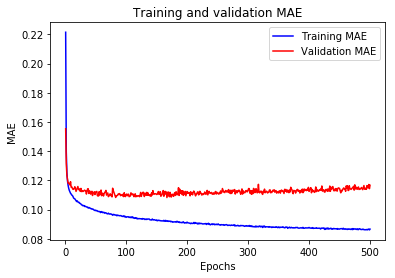

In [13]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(number_of_epochs)]
average_val_mae_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(number_of_epochs)]

epochs = range(1, number_of_epochs + 1)

plt.plot(epochs, average_mae_history, "b", label="Training MAE")
plt.plot(epochs, average_val_mae_history, "b", label="Validation MAE", c="red")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.show()

## Evaluate results for age prediction

In [6]:
results_age = model.predict(samples_without_age.drop(["Survived", "Age"], axis=1))
samples_without_age.loc[:,"Age"] = results_age
samples_without_age

/home/victor/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
6,0.0,1.0,0.454432,0.0,0.000000,0.016510,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1.0,0.5,0.398320,0.0,0.000000,0.025374,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,1.0,0.380821,0.0,0.000000,0.014102,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,1.0,0.358055,0.0,0.000000,0.014102,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,1.0,1.0,0.308788,0.0,0.000000,0.015379,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NaN,1.0,0.309024,0.0,0.000000,0.015070,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1302,NaN,1.0,0.308981,0.0,0.000000,0.015127,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,NaN,1.0,0.348813,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save data

In [7]:
normalized_data_with_predicted_age = pd.concat([samples_with_age, samples_without_age])
normalized_data_with_predicted_age.to_csv("normalized_data_with_predicted_age.csv", index=True)
normalized_data_with_predicted_age

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.271174,0.2,0.000000,0.014151,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.472229,0.2,0.000000,0.139136,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.434531,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NaN,1.0,0.309024,0.0,0.000000,0.015070,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1302,NaN,1.0,0.308981,0.0,0.000000,0.015127,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,NaN,1.0,0.348813,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare skewness of original and predicted Age

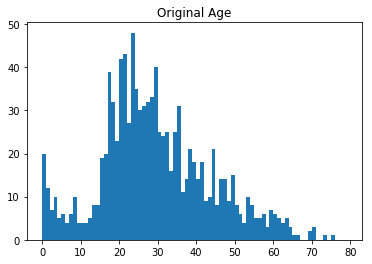

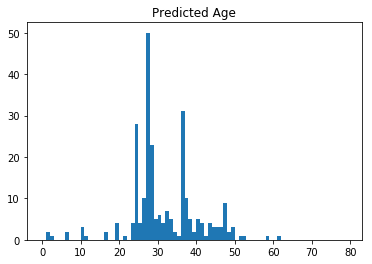

In [8]:
import matplotlib.pyplot as plt
scalar = 80

plt.hist(samples_with_age.Age*scalar, range(scalar))
plt.title("Original Age")
plt.show()

plt.hist(results_age*scalar, range(scalar))
plt.title("Predicted Age")
plt.show()